#### **Task 1**
 - Implement a LSTM (LSTM() and/or LSTMCell()) from scratch
 - Implement a Convolutional LSTM (ConvLSTM() and/or ConvLSTMCell()) from scratch

In [1]:
import torch
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import shutil
from torch.utils.tensorboard import SummaryWriter

# from Custom_Cell import ConvLSTMCell;

/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-05-19 23:35:58.748723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 23:35:59.820092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size,kernel_size=3,padding=1, bias=True):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: int
            Number of channels of input tensor.
        hidden_size: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Linear layer to compute all gates at once
        # Note: 4 * hidden_size for i, f, o, g (input, forget, output, candidate)
        
        self.f_t = nn.Conv1d(in_channels=input_size + hidden_size,
        out_channels=hidden_size,  # Matches hidden state dim
        kernel_size=kernel_size,
        padding=padding,
        bias=bias # To maintain spatial dims
        )
        self.i_t =nn.Conv1d(in_channels=input_size + hidden_size,
        out_channels=hidden_size,  # Matches hidden state dim
        kernel_size=kernel_size,
        padding=padding,
        bias=bias # To maintain spatial dims
        )

        self.c_hat_t =nn.Conv1d(in_channels=input_size + hidden_size,
        out_channels=hidden_size,  # Matches hidden state dim
        kernel_size=kernel_size,
        padding=padding,
        bias=bias # To maintain spatial dims
        )
        
        self.o_t = nn.Conv1d(in_channels=input_size + hidden_size,
        out_channels=hidden_size,  # Matches hidden state dim
        kernel_size=kernel_size,
        padding=padding,
        bias=bias # To maintain spatial dims
        )

        self.linear = nn.Linear(input_size + hidden_size, 4 * hidden_size)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        
        gates = self.linear(combined)  # Shape: (batch, 4 * hidden_size)
        
        # Split into input, forget, output, and candidate gates
        #cc_i, cc_f, cc_o, cc_g = gates.chunk(4, dim=1)  # Each shape: (batch, hidden_size)
        
        f_t=torch.sigmoid(self.f_t(combined).T)
        i_t=torch.sigmoid(self.i_t(combined).T)
        c_hat_t=torch.tanh(self.c_hat_t(combined).T)
        o_t=torch.sigmoid(self.o_t(combined).T)
        
        c_t=f_t*c_cur+i_t*c_hat_t
        h_t=o_t*torch.tanh(c_t)
        
        return h_t, c_t

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_size, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_size, height, width, device=self.conv.weight.device))


torch.Size([4, 1, 32, 32])
cuda Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): AdaptiveAvgPool2d(output_size=(1, 1))
)


Epoch 1 Iter 235: loss 1.38534. : 100%|██████████| 235/235 [00:47<00:00,  4.95it/s]


Epoch 1/10
    Train loss: 1.38839
    Valid loss: 1.38674
    Accuracy: 25.61%




Epoch 2 Iter 235: loss 1.38716. : 100%|██████████| 235/235 [00:48<00:00,  4.89it/s]


Epoch 2/10
    Train loss: 1.38758
    Valid loss: 1.38869
    Accuracy: 24.46%




Epoch 3 Iter 235: loss 1.38707. : 100%|██████████| 235/235 [00:47<00:00,  4.91it/s]


Epoch 3/10
    Train loss: 1.38731
    Valid loss: 1.38718
    Accuracy: 24.65%




Epoch 4 Iter 235: loss 1.38618. : 100%|██████████| 235/235 [00:33<00:00,  6.93it/s]


Epoch 4/10
    Train loss: 1.38696
    Valid loss: 1.3876
    Accuracy: 24.82%




Epoch 5 Iter 235: loss 1.38661. : 100%|██████████| 235/235 [00:34<00:00,  6.89it/s]


Epoch 5/10
    Train loss: 1.38663
    Valid loss: 1.3863
    Accuracy: 25.290000000000003%




Epoch 6 Iter 235: loss 1.38345. : 100%|██████████| 235/235 [00:27<00:00,  8.50it/s]


Epoch 6/10
    Train loss: 1.38671
    Valid loss: 1.38756
    Accuracy: 25.3%




Epoch 7 Iter 235: loss 1.38702. : 100%|██████████| 235/235 [00:33<00:00,  6.93it/s]


Epoch 7/10
    Train loss: 1.38646
    Valid loss: 1.38674
    Accuracy: 24.94%




Epoch 8 Iter 235: loss 1.38594. : 100%|██████████| 235/235 [00:35<00:00,  6.59it/s]


Epoch 8/10
    Train loss: 1.38672
    Valid loss: 1.38709
    Accuracy: 24.91%




Epoch 9 Iter 235: loss 1.38574. : 100%|██████████| 235/235 [00:44<00:00,  5.24it/s]


Epoch 9/10
    Train loss: 1.38663
    Valid loss: 1.38634
    Accuracy: 24.93%




Epoch 10 Iter 235: loss 1.38346. : 100%|██████████| 235/235 [00:45<00:00,  5.15it/s]


Epoch 10/10
    Train loss: 1.38667
    Valid loss: 1.3865
    Accuracy: 25.119999999999997%


Training completed


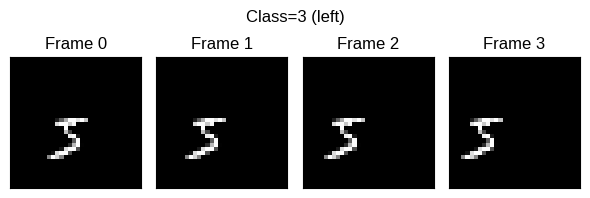

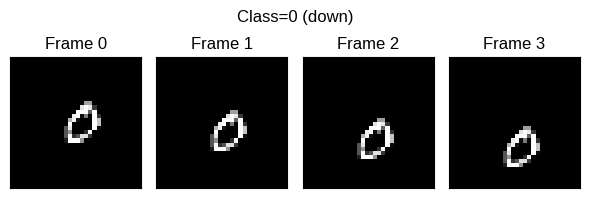

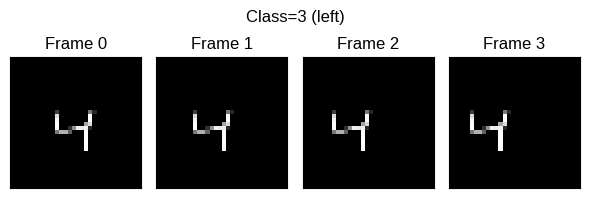

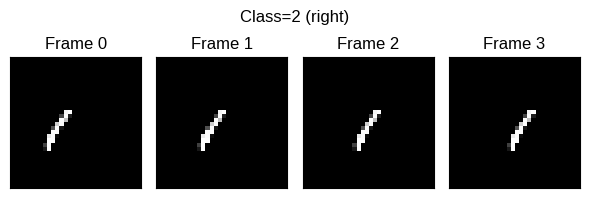

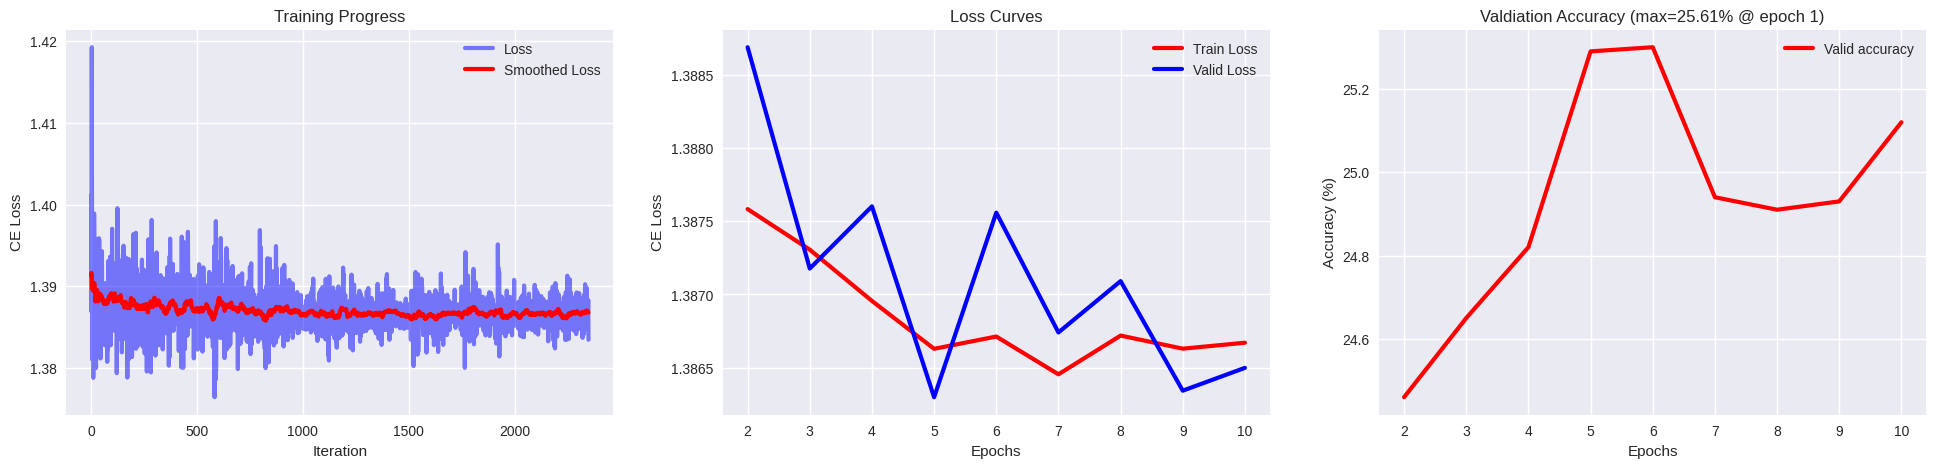

In [3]:
class MotionDataset:
    
    """
    Dataset for motion classification
    """
    
    LABELS = {
        0: "down",
        1: "up",
        2: "right",
        3: "left"
    }
    
    def __init__(self, train, transform, img_size=(64, 64), num_frames=5, resize=1, move=2):
        """ """ 
        self.img_size = img_size
        self.num_frames = num_frames
        self.resize = resize
        self.move = move
        self.mnist_db = datasets.MNIST(root='./data', train=train, transform=transform, download=True)
        return

    def __len__(self):
        """ """
        return len(self.mnist_db)
    
    def __getitem__(self, i):
        """ Creating a random sequence of a moving digit"""
        # sampling digit
        digit = self.mnist_db[i][0]
        digit = F.interpolate(digit.unsqueeze(0), scale_factor=1/self.resize)[0]
        digitH, digitW = digit.shape[-2], digit.shape[-1]
        
        # creating canvas
        canvasH, canvasW = self.img_size
        canvas = torch.zeros(self.num_frames, 1, canvasH, canvasW)
        start_pos_x = np.random.randint(3, canvasH - 3 - digitH)
        start_pos_y = np.random.randint(3, canvasH - 3 - digitH)
        start_pos = torch.tensor([start_pos_y, start_pos_x])
        
        # moving parameters
        n = np.random.rand()
        
        if n < 0.25:
            move = torch.tensor([self.move, 0])
            label = 0
        elif n < 0.5:
            move = torch.tensor([-self.move, 0])
            label = 1
        elif n < 0.75:
            move = torch.tensor([0, self.move])
            label = 2
        else:
            move = torch.tensor([0, -self.move])
            label = 3
        
        # updating positions and creating video
        positions = []
        for i in range(self.num_frames):
            if i == 0:
                cur_pos = start_pos
            else:
                cur_pos = positions[-1] + move
                if cur_pos[0] < 0 or cur_pos[0] >= canvasH - digitH or \
                   cur_pos[1] < 0 or cur_pos[1] >= canvasW - digitW:  # avoid going out of bounds
                    cur_pos = positions[-1]
            positions.append(cur_pos)
            canvas[i, :, cur_pos[0]:cur_pos[0]+digitH, cur_pos[1]:cur_pos[1] + digitW] = digit
        
        return canvas, label
    
def visualize_sequence(sequence,  suptitle="", add_title=True, add_axis=False, n_cols=5, size=1.5,  vmax=1, vmin=0, **kwargs):
    """ Visualizing a grid with several images/frames """
    n_frames = sequence.shape[0]
    n_rows = int(np.ceil(n_frames / n_cols))

    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(size * n_cols, size + 0.5)
    fig.suptitle(suptitle)
 
    ims = []
    fs = []
    for i in range(n_frames):
        a = ax[i]
        f = sequence[i, 0].cpu().detach()
        a.imshow(f, vmin=vmin, vmax=vmax, **kwargs)
        if add_title:
            a.set_title(f"Frame {i}", fontsize=12)
        if not add_axis:
            a.set_yticks([])
            a.set_xticks([])
    plt.tight_layout()
    return

train_dataset = MotionDataset(
        train=True,
        transform=transforms.ToTensor(),
        img_size=(32, 32),
        num_frames=4,
        resize=2
    )

test_dataset = MotionDataset(
        train=False,
        transform=transforms.ToTensor(),
        img_size=(32, 32),
        num_frames=4,
        resize=2
    )

frames, label = train_dataset[0]
print(frames.shape)


class LSTMWithCustomCell(nn.Module):
    """ 
    Sequential classifier. Embedded images are fed to a RNN
    Same as above, but using LSTMCells instead of the LSTM object
    
    Args:
    -----
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode

        # for embedding rows into vector representations
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(128, emb_dim, 3, 1, 1),
                nn.AdaptiveAvgPool2d((1, 1))
            )
        
        # LSTM model       
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            #lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
            lstms.append( ConvLSTMCell(input_size=in_size, hidden_size=hidden_dim) )
            
        self.lstm = nn.ModuleList(lstms)
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=4)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, num_frames, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x = x.view(b_size * num_frames, n_channels, n_rows, n_cols)
        embeddings = self.encoder(x)
        embeddings = embeddings.reshape(b_size, num_frames, -1)
        
        # iterating over sequence length
        lstm_out = []
        for i in range(embeddings.shape[1]):  # iterate over time steps
            lstm_input = embeddings[:, i, :]  # size= (batch_size, emb_dim) 
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                #try:
                    if lstm_input.shape[0] != B_SIZE:
                        continue
                    #print(lstm_input.shape)
                    h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                    lstm_input = h[j]
                #except:
                    #lstm_input=lstm_input;
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
            
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h, c

for i in range(4):
    frames, label = train_dataset[i]
    visualize_sequence(frames, n_cols=4, cmap="gray", suptitle=f"Class={label} ({train_dataset.LABELS[label]})")

# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMWithCustomCell(emb_dim=128, hidden_dim=128, num_layers=2, mode="zeros")
count_model_params(model)
print(device, model.encoder)
count_model_params(model.encoder)
model = model.to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=6e-3)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

TBOARD_LOGS = os.path.join(os.getcwd(),"..", "tboard_logs", "OwnConvLSTM")
if os.path.exists(TBOARD_LOGS):
    shutil.rmtree(TBOARD_LOGS) # To discard old log files
os.makedirs(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=None, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, tboard=writer, device=device,
    )


plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()